Vid Sustar <br>
student number 508706 <br>
vid.sustar@utu.fi  <br>
29.1.2020  <br>

# Exercise 2 | TKO_2096 Application of Data Analysis 2020

#### Prediction of the metal ion content from multi-parameter data <br>
- Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), for each sample using number of neighbors k = 3.<br> <br>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score.
    - Implement your own Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement your own Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - This exercise provides a bonus point: see "Bonus exercise" in this notebook for details.
    - Return your solution as a Jupyter Notebook file (include your full name in the file name).
    - Submit to moodle your solution on **Wednesday 29. of January** at the latest.

## Import libraries

In [1]:
%matplotlib inline
import pandas
import pandas as pd
import math 
from sklearn.neighbors import KNeighborsRegressor
import random
from numpy.random import permutation
import numpy as np
import matplotlib.pyplot as plt

## Read and visualize the dataset

In [46]:
#In this cell read the file water_data.csv
#Print the dataset dimesions (i.e. number of rows and columns)

with open("water_data.csv", 'r') as csvfile:
    water = pandas.read_csv(csvfile)


x_columns = ['Mod1', 'Mod2', 'Mod3']
# The columns that we want to predict.
y_columns = ['c_total', 'Cd', 'Pb']
water_numeric = water[x_columns]
# Standardize the Mod columns
rows,cols=water.shape
print("Data has: #rows: ",rows," #columns: ",cols)
display(water.info)


Data has: #rows:  225  #columns:  6


<bound method DataFrame.info of      c_total      Cd      Pb    Mod1  Mod2    Mod3
0       2000   800.0  1200.0  126430  2604    6996
1         35    14.0    21.0   20597   271  138677
2         35    14.0    21.0   24566   269  161573
3         35    35.0     0.0  105732   971  132590
4        100    20.0    80.0   57774  5416   93798
..       ...     ...     ...     ...   ...     ...
220     2000     0.0  2000.0   45323  2759    5101
221     5000  4000.0  1000.0   22396   563    7454
222       50    30.0    20.0   49520  2261  210270
223       50     0.0    50.0   17201   293  118509
224     2000   800.0  1200.0  127269  2453    7420

[225 rows x 6 columns]>

#### To show understanding of the data, answer the following questions:
- How many different mixtures of Cadmium (Cd) and Lead (Pb) were measured? <br>
- How many total concentrations (c_total) were measured? <br>
- For each c_total, how many times the measurement was repeated? To answer this question <br>
  create a table or make a bar plot of c_total / number of repetitions 

Number of different Cd concentrations:  40
Number of different Pb concentrations:  40
Number of total concentrations measurements:  225
Number of different total concentrations:  12

 Count of different total concentrations:
         count
c_total       
0            3
14          18
20          18
35          18
50          24
70          24
100         24
200         24
500         18
1000        18
2000        18
5000        18


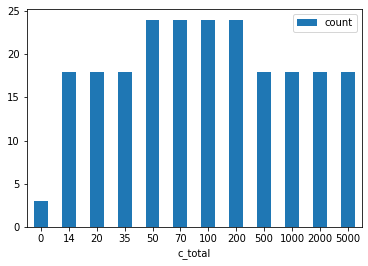

In [54]:
print("Number of different Cd concentrations: ",water['Cd'].nunique())
print("Number of different Pb concentrations: ",water['Pb'].nunique())

print("Number of total concentrations measurements: ",water['c_total'].count())
print("Number of different total concentrations: ",water['c_total'].nunique())

dups_tot_conc = water.pivot_table(index=['c_total'], aggfunc='size')

print ('\n Count of different total concentrations:')

df = pd.DataFrame({'count': dups_tot_conc.values}, index=dups_tot_conc.index)
print(df)
ax = df.plot.bar(rot=0)

## Standardization of the dataset

In [55]:
#Standardize the dataset features by removing the mean and scaling to unit variance. 
#In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
#Print the 5 first samples (i.e. rows) of the scaled dataset
water[x_columns] = (water_numeric - water_numeric.mean()) / water_numeric.std() #standardization!
# Randomly shuffle the index of water.
ordered_indices=np.argsort(water.index)


## C-index code 

In [56]:
def c_index_calc(true_labels, predictions):
    n=0
    h_sum=0
    #print("len(true_labels)",len(true_labels))
    for i in range(0,len(true_labels)): 
        t=true_labels[i]
        p=predictions[i]
        for j in range(i+1, len(true_labels)):
            nt=true_labels[j]
            np=predictions[j]
            #print("t,nt",t,nt)
            if(t!=nt):
                n=n+1
                if((p<np) and (t<nt)) or ((p>np) and (t>nt)):
                    h_sum=h_sum+1
                elif(p==np):
                    h_sum=h_sum+0.5
    c_index=h_sum/n
    return c_index

In [57]:
#test cindex function with following values
true_labels = [-1, 1, 1, -1, 1]
predictions = [0.60, 0.80, 0.75, 0.75, 0.70]
cindx = c_index_calc(true_labels, predictions)
print(cindx)

0.75


## Functions

In [58]:
# The columns that we will be making predictions with.
def cross_validation(y_column,dataset,folds, repout,k):
    actual=[]
    predictions=[]
    for i in range(folds):
        testStart = int(i*(len(dataset)/folds)) #dividing the initial training set into subtesting and subtrainning in ratio 1/# folds
        testEnd = int((i+1)*(len(dataset)/folds))       
        ordered_indices=np.argsort(dataset.index)
        test = dataset.loc[ordered_indices[testStart:testEnd]]
        train2 = dataset.loc[ordered_indices[testEnd:]]
        train1 = dataset.loc[ordered_indices[:testStart]]
        train=pd.concat([train1, train2])
        if repout:
            test_c_tot=test.iloc[0]['c_total']
            test_Cd=test.iloc[0]['Cd']
            test_Pb=test.iloc[0]['Pb']
            train=train.loc[(train.c_total != test_c_tot) & (train.Cd != test_Cd) & (train.Pb != test_Pb), :]
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train[x_columns], train[y_column])
        actual.append(test[y_column].tolist()[0] )
        predictions.append(int(knn.predict(test[x_columns]).tolist()[0])) 
    c_indx=c_index_calc(actual, predictions)
    return(c_indx)
    
output_list=['c_total', 'Cd', 'Pb']
k_list=[1, 2, 3, 4, 5]



## Results for Leave-One-Out cross-validation

In [59]:

print("For Leave-One-Out cross-validation:")
for output in output_list:
    print("\tFOR OUTPUT: ", output)
    for k in k_list:
        c_ind_list=[]

        cindex=cross_validation(output,water,len(water)-1,0,k)
        c_ind_list.append(cindex)
        print("\t\tFOR k: ", k,"NEIGHBOURS, C INDEX IS: {0:.3f}".format(cindex))


For Leave-One-Out cross-validation:
	FOR OUTPUT:  c_total
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.908
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.913
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.914
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.906
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.893
	FOR OUTPUT:  Cd
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.921
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.915
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.898
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.879
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.862
	FOR OUTPUT:  Pb
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.879
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.884
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.873
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.860
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.853


## Results for Leave-Replicas-Out cross-validation

In [60]:

print("For Leave-Replicas-Out cross-validation:")
for output in output_list:
    print("\tFOR OUTPUT: ", output)
    for k in k_list:
        c_ind_list=[]

        cindex=cross_validation(output,water,len(water)-1,1,k)
        c_ind_list.append(cindex)
        print("\t\tFOR k: ", k,"NEIGHBOURS, C INDEX IS: {0:.3f}".format(cindex))

For Leave-Replicas-Out cross-validation:
	FOR OUTPUT:  c_total
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.774
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.765
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.764
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.759
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.763
	FOR OUTPUT:  Cd
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.566
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.552
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.544
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.542
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.540
	FOR OUTPUT:  Pb
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.664
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.667
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.670
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.669
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.667


## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation approach had more optimistic results?
- Which cross-validation generalize better on unseen data? Why?

Which cross-validation approach had more optimistic results? Leave one out.
Which cross-validation generalize better on unseen data? Why? The one where we removed the replicas out of training data. 
Because the training and test data should have independent data.

## Bonus exercise
Using K-Nearest Neighbor Regression where k = 1, 2, 3, 4, 5 compute the corresponding C-indices for the outputs (c_total, Cd, Pb) with Leave-One-Out and with Leave-Replicas-Out cross-validation. Plot your results as k / C-index for each output. 

For Leave-One-Out cross-validation:
	FOR OUTPUT:  c_total
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.908
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.913
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.914
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.906
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.893


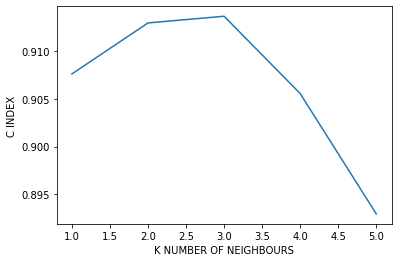

	FOR OUTPUT:  Cd
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.921
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.915
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.898
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.879
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.862


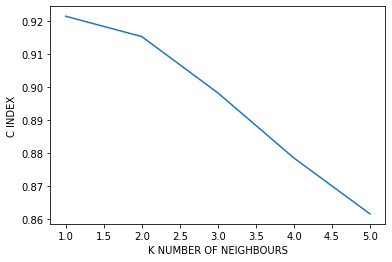

	FOR OUTPUT:  Pb
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.879
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.884
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.873
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.860
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.853


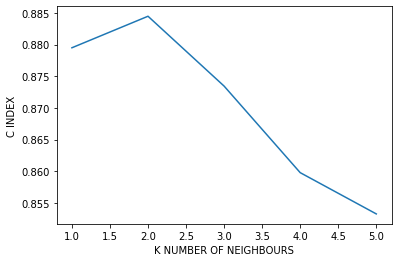

For Leave-Replicas-Out cross-validation:
	FOR OUTPUT:  c_total
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.774
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.765
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.764
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.759
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.763


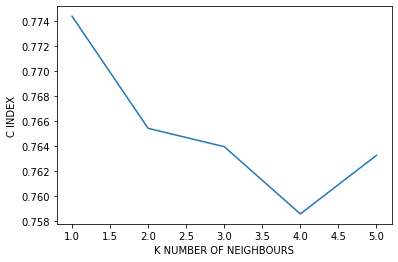

	FOR OUTPUT:  Cd
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.566
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.552
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.544
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.542
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.540


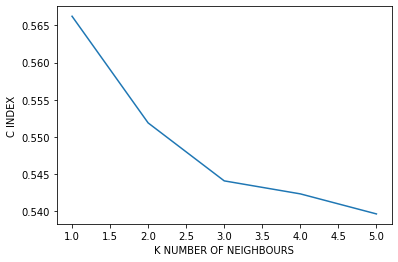

	FOR OUTPUT:  Pb
		FOR k:  1 NEIGHBOURS, C INDEX IS: 0.664
		FOR k:  2 NEIGHBOURS, C INDEX IS: 0.667
		FOR k:  3 NEIGHBOURS, C INDEX IS: 0.670
		FOR k:  4 NEIGHBOURS, C INDEX IS: 0.669
		FOR k:  5 NEIGHBOURS, C INDEX IS: 0.667


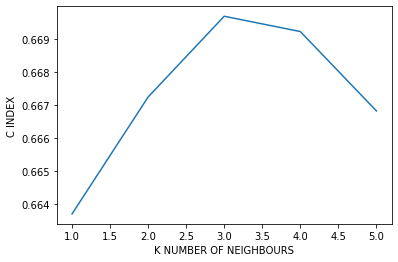

In [61]:
#SEE ABOVE #Write and run the code for Extra work section in this cell.

print("For Leave-One-Out cross-validation:")
for output in output_list:
    print("\tFOR OUTPUT: ", output)
    c_ind_list=[]
    for k in k_list:
        cindex=cross_validation(output,water,len(water)-1,0,k)
        c_ind_list.append(cindex)
        print("\t\tFOR k: ", k,"NEIGHBOURS, C INDEX IS: {0:.3f}".format(cindex))
    #print(c_ind_list)
    plt.plot(k_list,c_ind_list)
    plt.ylabel('C INDEX')
    plt.xlabel('K NUMBER OF NEIGHBOURS')
    plt.show()

print("For Leave-Replicas-Out cross-validation:")
for output in output_list:
    print("\tFOR OUTPUT: ", output)
    c_ind_list=[]
    for k in k_list:
        cindex=cross_validation(output,water,len(water)-1,1,k)
        c_ind_list.append(cindex)
        print("\t\tFOR k: ", k,"NEIGHBOURS, C INDEX IS: {0:.3f}".format(cindex))
    #print(c_ind_list)
    plt.plot(k_list,c_ind_list)
    plt.ylabel('C INDEX')
    plt.xlabel('K NUMBER OF NEIGHBOURS')
    plt.show()